In [1]:
import warnings, torch
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
pl.seed_everything(123)

from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, DeepAR, RecurrentNetwork, GroupNormalizer
from pytorch_forecasting.metrics import MAPE, NormalDistributionLoss, QuantileLoss, SMAPE

from math import floor
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

from AnalyzeTools.models import autoregressive_integrated_moving_average, linear_regression, support_vector_regression, random_forest, gradient_boosting
from AnalyzeTools.prepare import data_split, model_eval, pathForSavingModels, retriveBestModelPath
from AnalyzeTools.preprocess import preprocessData
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

params_path = './Models'

c:\Users\zyf13\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 123


In [2]:
''' Read data '''
raw_file_name = '경략가격집계 - 소,돼지'
product = "pork-hot"
product_attribute = "경락가격"

_output = 'MAX_COST_AMT' # MIN_COST_AMT
default_exclude_cols = ['JUDGE_GUBN', 'JUDGE_BREED', 'JUDGE_SEX', 'SABLE_GUBN', 'ABATT_CODE']

df = pd.read_csv('../Data/beef/경략가격집계 - 소,돼지.csv', encoding = 'euc_kr', engine ='python').query("JUDGE_KIND == 2")

df = df.drop(default_exclude_cols, axis=1)
df = df.groupby(['STD_DATE']).mean().reset_index()
df['STD_DATE'] = df['STD_DATE'].apply(lambda x: "20" + "-".join(x.split("/")))

df, _input = preprocessData(df, 'STD_DATE', _output)


Feature scores:
                 Features        Scores
6  DEFECT_MAX_COST_AMT  6.811574e+10
1         MIN_COST_AMT  1.222592e+04
5  DEFECT_MIN_COST_AMT  1.222443e+04
2         SUM_COST_AMT  4.538033e+02
7  DEFECT_SUM_COST_AMT  4.537454e+02
8    DEFECT_SUM_WEIGHT  2.279391e+01
3           SUM_WEIGHT  2.277102e+01
4           DEFECT_CNT  1.084715e+01
0                  CNT  1.083094e+01

TOP K features:
   ['MIN_COST_AMT', 'SUM_COST_AMT', 'DEFECT_MIN_COST_AMT', 'DEFECT_MAX_COST_AMT']


In [3]:
ml_split_params = {'Model': 'ML', 'Future': 1}
X_train, X_test, y_train, y_test, input_scaler, output_scaler = data_split(df, input_cols=_input, output=_output, train_size=0.8, scaling=True, **ml_split_params)

X_train: (2037, 3) y_train: (2037,) X_test: (510, 3) y_test: (510,)


In [4]:
ml_searchCV_params = {
    'base_dir': params_path,
    'product': product,
    'attribute': product_attribute,
    'raw': raw_file_name,
}

model, best_params = support_vector_regression(X_train, y_train, search=True, save=True, **ml_searchCV_params)

--> Use the existed best parameters!

Best parameter for Random forest is:
  {'C': 1, 'gamma': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}


MAPE: 0.05267436613796004 R square: 0.719514968812925


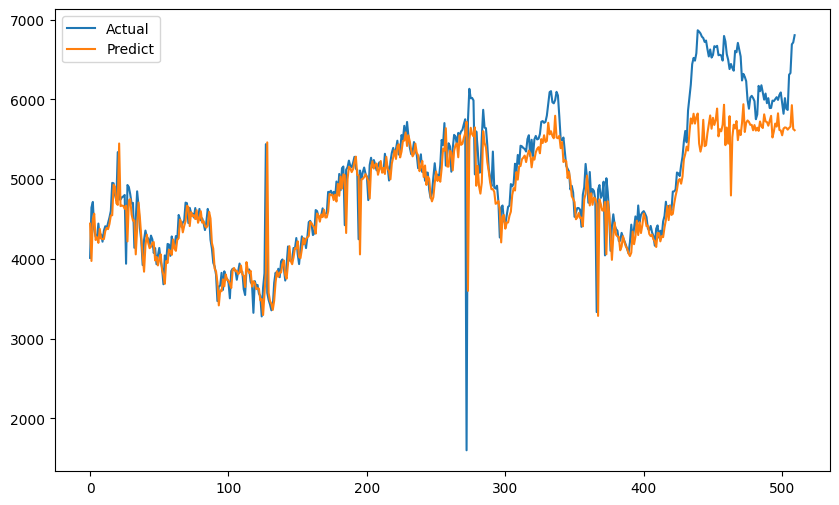

In [5]:
predictions = model.predict(X_test)
model_eval(y_test, predictions, stdout=True, vis=True, **{'scaler': output_scaler})

In [6]:
# data = df.copy()

# data['time_idx'] = range(len(data))
# data['group'] = product

# training_cutoff = floor(len(data) * 0.8)

# max_prediction_length = 1
# max_encoder_length = 30 # 7, 14, 30, 60, 120
# batch_size = 64

# group = ['group']
# time_varying_known_categoricals = ['month', 'week']
# time_varying_unknown_categoricals = []
# time_varying_known_reals = ['time_idx']
# time_varying_unknown_reals = _input + [_output]

# cell = 'LSTM'
# saving_dir = pathForSavingModels(product, product_attribute, raw_file_name, 'LSTM')
# best_model_path = retriveBestModelPath(saving_dir)

# print(f"time_varying_known_categoricals: {time_varying_known_categoricals}")
# print(f"time_varying_unknown_categoricals: {time_varying_unknown_categoricals}")
# print(f"time_varying_known_reals: {time_varying_known_reals}")
# print(f"time_varying_unknown_reals: {time_varying_unknown_reals}")

# data[time_varying_known_categoricals] = data[time_varying_known_categoricals].astype(str).astype("category")
# training = TimeSeriesDataSet(
#     data[lambda x: x.time_idx <= training_cutoff],
#     time_idx="time_idx",
#     target=_output,
#     group_ids=group,
#     max_encoder_length=max_encoder_length,
#     max_prediction_length=max_prediction_length,
#     time_varying_known_categoricals=time_varying_known_categoricals,
#     time_varying_unknown_categoricals=time_varying_unknown_categoricals,
#     time_varying_known_reals=time_varying_known_reals+[i for i in time_varying_unknown_reals if i != _output],
#     time_varying_unknown_reals=[_output],
# )

# validation = TimeSeriesDataSet.from_dataset(
#     training, 
#     data, 
#     min_prediction_idx=training.index.time.max() + 1,
#     stop_randomization=True
# )

# train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

# for x, y in iter(val_dataloader):
#     for k in x.keys():
#         print(f"\n{k}:\n  {x[k]}")
#     print(f"\ny:\n  {y}")
#     break

# if not best_model_path:
#     early_stop_callback = EarlyStopping(monitor="val_loss", verbose=False, mode="min")
#     lr_logger = LearningRateMonitor()

#     trainer = pl.Trainer(
#         max_epochs=100,
#         gpus=0,
#         weights_summary='top',
#         callbacks=[lr_logger, early_stop_callback],
#         log_every_n_steps=10,
#         default_root_dir=saving_dir,
#     )

#     model = RecurrentNetwork.from_dataset(
#         training,
#         cell_type=cell,
#         hidden_size=128,
#         rnn_layers=1,
#         dropout=0.1,
#         output_size=1,
#         loss=MAPE(),
#         log_interval=10
#     )

#     trainer.fit(
#         model,
#         train_dataloaders=train_dataloader,
#         val_dataloaders=val_dataloader
#     )

# best_model_path = retriveBestModelPath(saving_dir)
# best_model = RecurrentNetwork.load_from_checkpoint(best_model_path, cell_type=cell)

# actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
# predictions = best_model.predict(val_dataloader)
# model_eval(actuals, predictions, stdout=True, vis=True)